In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Reshape, Flatten,
                                     LeakyReLU, BatchNormalization, Input,
                                     Conv2D, UpSampling2D)
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Konfigurasi
LATENT_DIM = 100
BATCH_SIZE = 128
EPOCHS = 50
IMG_SHAPE = (28, 28, 1)

class BalancedDCGAN:
    def __init__(self):
        self.latent_dim = LATENT_DIM
        self.img_shape = IMG_SHAPE

        # PERBAIKAN 1: LR Discriminator LEBIH TINGGI dari Generator
        self.d_optimizer = Adam(learning_rate=0.0003, beta_1=0.5)  # D lebih tinggi!
        self.g_optimizer = Adam(learning_rate=0.0001, beta_1=0.5)  # G lebih rendah!

        # Build models
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()

        # Compile discriminator
        self.discriminator.compile(
            loss='binary_crossentropy',
            optimizer=self.d_optimizer,
            metrics=['accuracy']
        )

        # Build dan compile GAN
        self.discriminator.trainable = False
        gan_input = Input(shape=(self.latent_dim,))
        gan_output = self.discriminator(self.generator(gan_input))
        self.gan = Model(gan_input, gan_output, name='gan')
        self.gan.compile(loss='binary_crossentropy', optimizer=self.g_optimizer)

    def build_generator(self):
        """Generator dengan Convolutional architecture"""
        model = Sequential(name='generator')

        # Foundation
        model.add(Dense(7 * 7 * 256, input_dim=self.latent_dim))
        model.add(BatchNormalization(momentum=0.9))
        model.add(LeakyReLU(negative_slope=0.2))
        model.add(Reshape((7, 7, 256)))

        # Upsampling 1: 7x7 -> 14x14
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding='same'))
        model.add(BatchNormalization(momentum=0.9))
        model.add(LeakyReLU(negative_slope=0.2))

        # Upsampling 2: 14x14 -> 28x28
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding='same'))
        model.add(BatchNormalization(momentum=0.9))
        model.add(LeakyReLU(negative_slope=0.2))

        # Output
        model.add(Conv2D(1, kernel_size=3, padding='same', activation='tanh'))

        return model

    def build_discriminator(self):
        """PERBAIKAN 2: Discriminator TANPA Dropout (lebih kuat!)"""
        model = Sequential(name='discriminator')

        # Conv block 1
        model.add(Conv2D(64, kernel_size=3, strides=2, padding='same',
                        input_shape=self.img_shape))
        model.add(LeakyReLU(negative_slope=0.2))
        # HAPUS DROPOUT!

        # Conv block 2
        model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
        model.add(LeakyReLU(negative_slope=0.2))
        # HAPUS DROPOUT!

        # Conv block 3
        model.add(Conv2D(256, kernel_size=3, strides=2, padding='same'))
        model.add(LeakyReLU(negative_slope=0.2))
        # HAPUS DROPOUT!

        # Classifier
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        return model

    def load_data(self):
        """Load dan preprocess data"""
        (X_train, _), (_, _) = mnist.load_data()
        X_train = X_train.astype('float32')
        X_train = (X_train - 127.5) / 127.5  # Normalize ke [-1, 1]
        X_train = np.expand_dims(X_train, axis=-1)
        return X_train

    def train(self, epochs, batch_size):
        """PERBAIKAN 3 & 4: Hapus label smoothing & train G hanya 1x"""
        X_train = self.load_data()

        # Untuk tracking
        history = {'d_loss': [], 'g_loss': [], 'd_acc': []}

        # PERBAIKAN 3: Label TANPA smoothing (real = 1.0, fake = 0.0)
        real_label = np.ones((batch_size, 1))  # 1.0 bukan 0.9!
        fake_label = np.zeros((batch_size, 1))

        print(f"\n{'='*70}")
        print(f"Training Balanced DCGAN: {epochs} epochs")
        print(f"Config: D_LR=0.0002 | G_LR=0.0001 | No Dropout | No Smoothing")
        print(f"{'='*70}\n")

        for epoch in range(epochs):
            epoch_d_loss = []
            epoch_g_loss = []
            epoch_d_acc = []

            n_batches = X_train.shape[0] // batch_size

            for batch in range(n_batches):
                # ---------------------
                # Train Discriminator (1x)
                # ---------------------
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                real_imgs = X_train[idx]

                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                fake_imgs = self.generator.predict(noise, verbose=0)

                # Train on real dan fake
                d_loss_real = self.discriminator.train_on_batch(real_imgs, real_label)
                d_loss_fake = self.discriminator.train_on_batch(fake_imgs, fake_label)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # ---------------------
                # PERBAIKAN 4: Train Generator HANYA 1x (bukan 2x!)
                # ---------------------
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                g_loss = self.gan.train_on_batch(noise, real_label)

                # Track metrics
                epoch_d_loss.append(d_loss[0])
                epoch_g_loss.append(g_loss)
                epoch_d_acc.append(d_loss[1])

                # Print progress
                if batch % 100 == 0:
                    print(f"Epoch {epoch+1}/{epochs} | Batch {batch}/{n_batches} | "
                          f"D_loss: {d_loss[0]:.4f} | D_acc: {d_loss[1]*100:.1f}% | "
                          f"G_loss: {g_loss:.4f}")

            # Epoch summary
            avg_d_loss = np.mean(epoch_d_loss)
            avg_g_loss = np.mean(epoch_g_loss)
            avg_d_acc = np.mean(epoch_d_acc) * 100

            history['d_loss'].append(avg_d_loss)
            history['g_loss'].append(avg_g_loss)
            history['d_acc'].append(avg_d_acc)

            print(f"\n{'='*70}")
            print(f"EPOCH {epoch+1} SUMMARY")
            print(f"D_loss: {avg_d_loss:.4f} | D_acc: {avg_d_acc:.1f}% | G_loss: {avg_g_loss:.4f}")

            # Status check
            if avg_d_acc < 30:
                print("⚠️  WARNING: D_acc too LOW - Generator dominating!")
            elif avg_d_acc > 80:
                print("⚠️  WARNING: D_acc too HIGH - Discriminator dominating!")
            elif 40 <= avg_d_acc <= 70:
                print("✅ GOOD: Training is balanced!")

            print(f"{'='*70}\n")

            # Generate samples
            if (epoch + 1) % 5 == 0 or epoch == 0:
                self.generate_images(epoch + 1)

        return history

    def generate_images(self, epoch, n=25):
        """Generate dan tampilkan images"""
        noise = np.random.normal(0, 1, (n, self.latent_dim))
        gen_imgs = self.generator.predict(noise, verbose=0)
        gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale ke [0, 1]

        dim = int(np.sqrt(n))
        fig, axes = plt.subplots(dim, dim, figsize=(10, 10))

        for i in range(dim):
            for j in range(dim):
                idx = i * dim + j
                axes[i, j].imshow(gen_imgs[idx, :, :, 0], cmap='gray')
                axes[i, j].axis('off')

        plt.suptitle(f'Generated Images - Epoch {epoch}', fontsize=16, y=0.98)
        plt.tight_layout()
        plt.show()

    def plot_history(self, history):
        """Plot training history"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        epochs = range(1, len(history['d_loss']) + 1)

        # Losses
        ax1.plot(epochs, history['d_loss'], label='Discriminator', linewidth=2, color='blue')
        ax1.plot(epochs, history['g_loss'], label='Generator', linewidth=2, color='orange')
        ax1.set_xlabel('Epoch', fontsize=12)
        ax1.set_ylabel('Loss', fontsize=12)
        ax1.set_title('Training Losses', fontsize=14, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Discriminator accuracy
        ax2.plot(epochs, history['d_acc'], color='green', linewidth=2)
        ax2.axhline(y=50, color='r', linestyle='--', linewidth=2, label='Ideal (50%)')
        ax2.fill_between(epochs, 40, 70, alpha=0.2, color='green', label='Good range (40-70%)')
        ax2.set_xlabel('Epoch', fontsize=12)
        ax2.set_ylabel('Accuracy (%)', fontsize=12)
        ax2.set_title('Discriminator Accuracy', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim([0, 100])

        plt.tight_layout()
        plt.show()

GENERATOR ARCHITECTURE


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,266,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 14, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,687,297 (6.44 MB)

 Trainable params: 1,661,825 (6.34 MB)

 Non-trainable params: 25,472 (99.50 KB)


DISCRIMINATOR ARCHITECTURE (No Dropout, More Filters)


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,761 (1.43 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 373,761 (1.43 MB)


Pre-training samples (should be noise)...


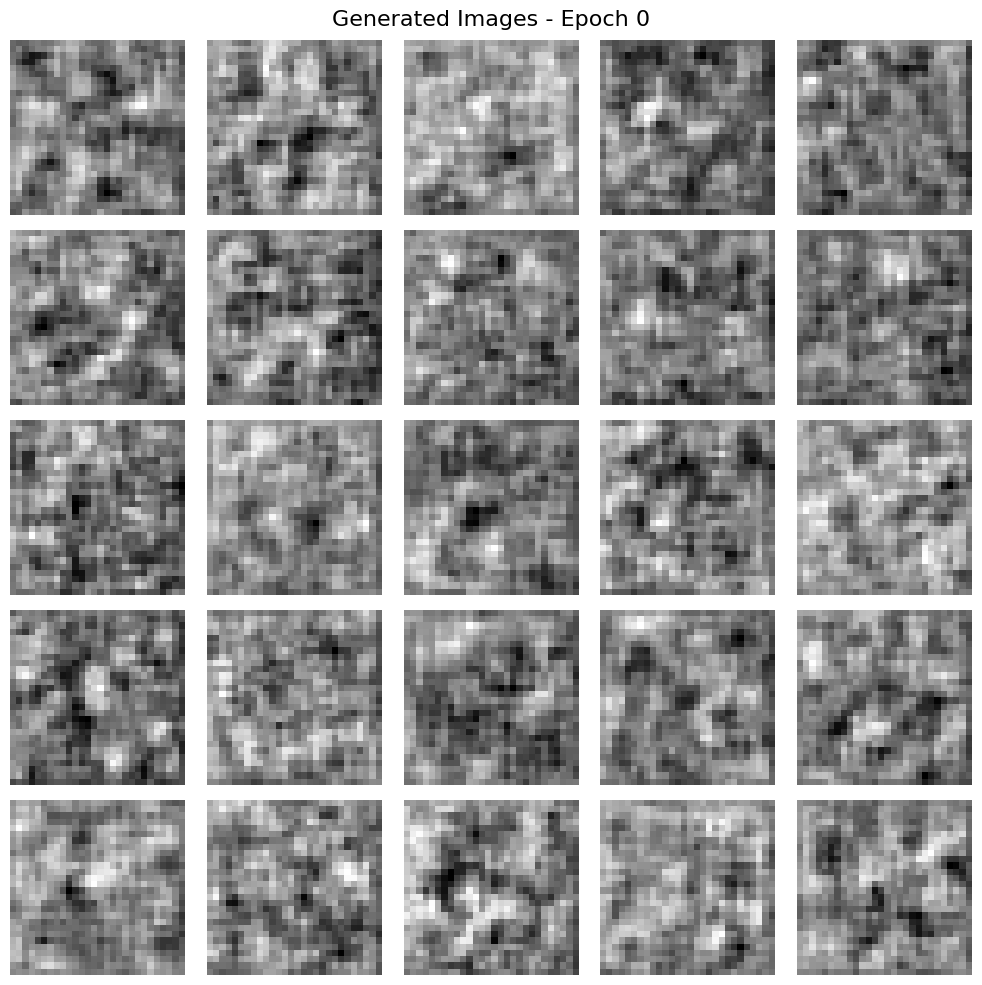


Starting training with balanced settings...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Training Balanced DCGAN: 50 epochs
Config: D_LR=0.0002 | G_LR=0.0001 | No Dropout | No Smoothing

Epoch 1/50 | Batch 0/468 | D_loss: 0.6688 | D_acc: 84.4% | G_loss: 0.6883
Epoch 1/50 | Batch 100/468 | D_loss: 0.7214 | D_acc: 50.6% | G_loss: 0.5978
Epoch 1/50 | Batch 200/468 | D_loss: 0.7575 | D_acc: 50.3% | G_loss: 0.5509
Epoch 1/50 | Batch 300/468 | D_loss: 0.7827 | D_acc: 50.2% | G_loss: 0.5192
Epoch 1/50 | Batch 400/468 | D_loss: 0.8019 | D_acc: 50.1% | G_loss: 0.4959

EPOCH 1 SUMMARY
D_loss: 0.7581 | D_acc: 50.7% | G_loss: 0.5517
✅ GOOD: Training is balanced!



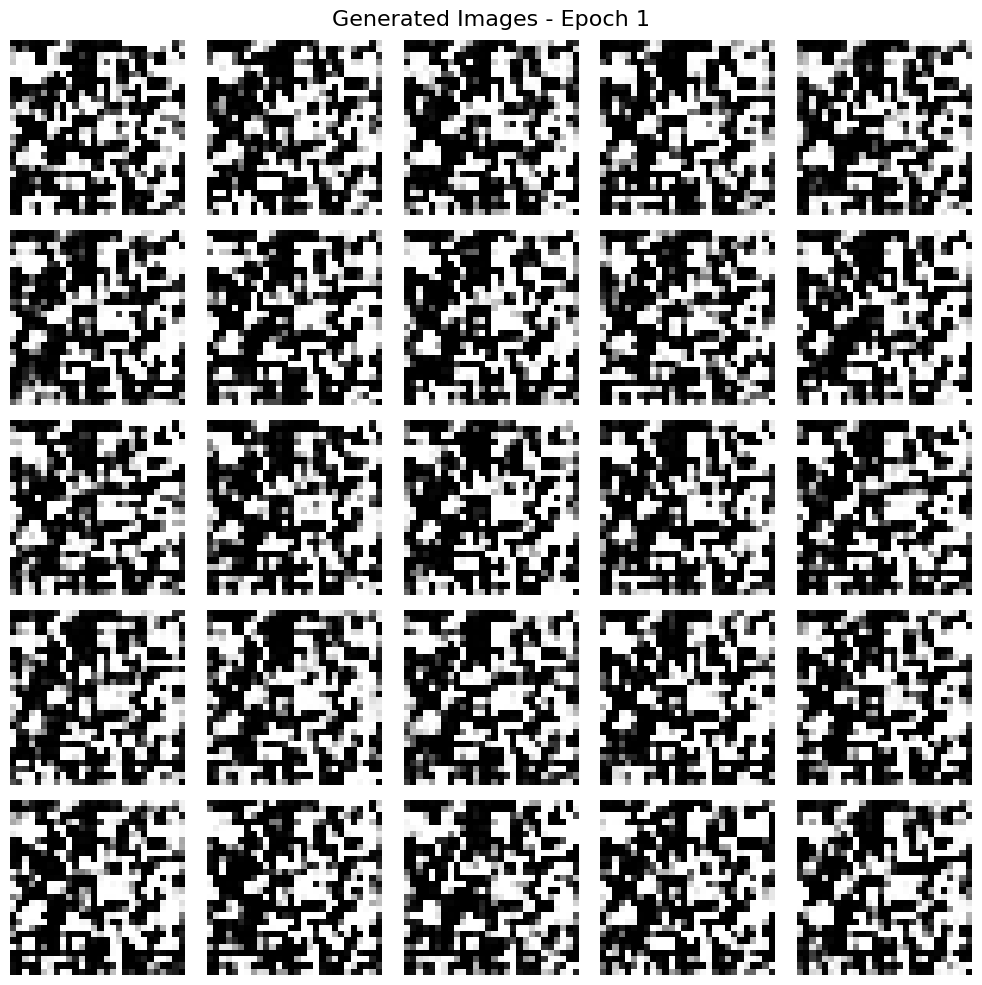

Epoch 2/50 | Batch 0/468 | D_loss: 0.8128 | D_acc: 50.1% | G_loss: 0.4832
Epoch 2/50 | Batch 100/468 | D_loss: 0.8264 | D_acc: 50.1% | G_loss: 0.4677
Epoch 2/50 | Batch 200/468 | D_loss: 0.8375 | D_acc: 50.0% | G_loss: 0.4554
Epoch 2/50 | Batch 300/468 | D_loss: 0.8468 | D_acc: 50.0% | G_loss: 0.4452
Epoch 2/50 | Batch 400/468 | D_loss: 0.8547 | D_acc: 50.0% | G_loss: 0.4368

EPOCH 2 SUMMARY
D_loss: 0.8393 | D_acc: 50.0% | G_loss: 0.4536
✅ GOOD: Training is balanced!

Epoch 3/50 | Batch 0/468 | D_loss: 0.8593 | D_acc: 50.0% | G_loss: 0.4318
Epoch 3/50 | Batch 100/468 | D_loss: 0.8654 | D_acc: 50.0% | G_loss: 0.4254
Epoch 3/50 | Batch 200/468 | D_loss: 0.8707 | D_acc: 50.0% | G_loss: 0.4199
Epoch 3/50 | Batch 300/468 | D_loss: 0.8753 | D_acc: 50.0% | G_loss: 0.4151
Epoch 3/50 | Batch 400/468 | D_loss: 0.8793 | D_acc: 50.0% | G_loss: 0.4109

EPOCH 3 SUMMARY
D_loss: 0.8717 | D_acc: 50.0% | G_loss: 0.4189
✅ GOOD: Training is balanced!

Epoch 4/50 | Batch 0/468 | D_loss: 0.8818 | D_acc: 50.

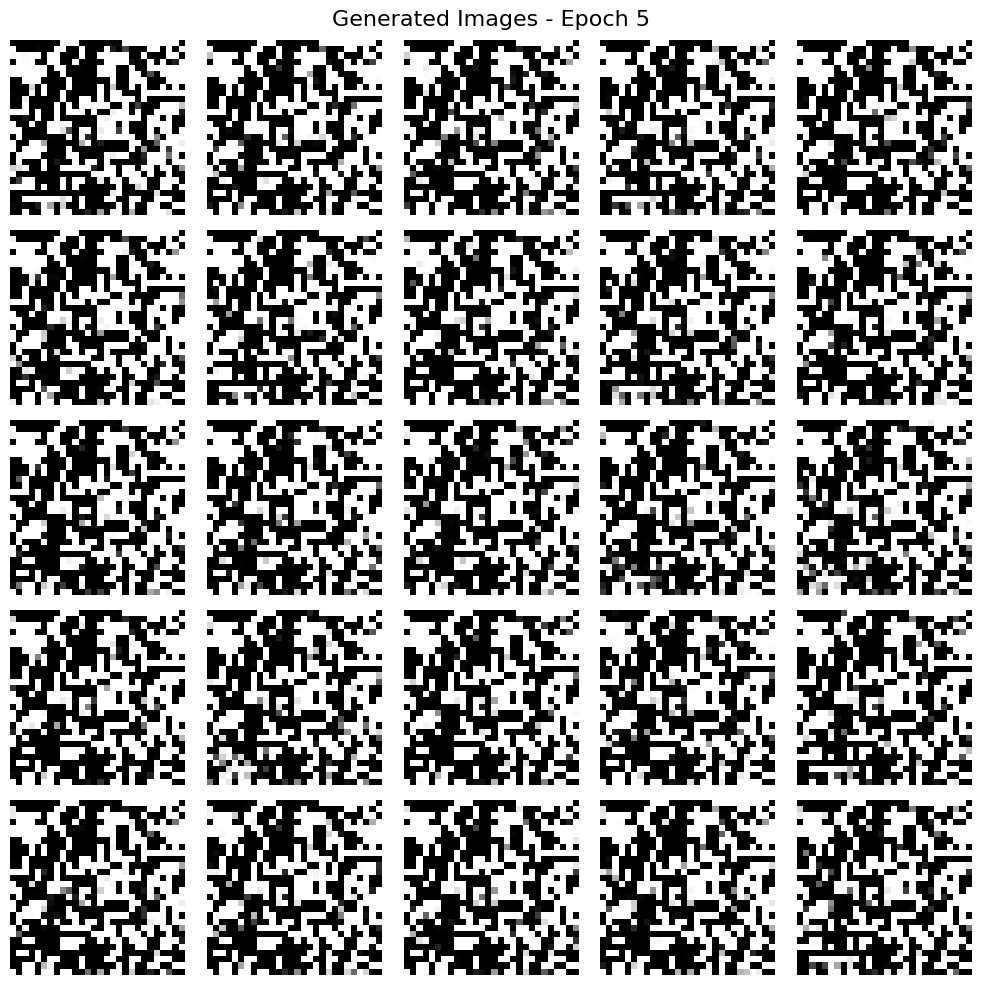

Epoch 6/50 | Batch 0/468 | D_loss: 0.9028 | D_acc: 50.0% | G_loss: 0.3871
Epoch 6/50 | Batch 100/468 | D_loss: 0.9042 | D_acc: 50.0% | G_loss: 0.3856
Epoch 6/50 | Batch 200/468 | D_loss: 0.9055 | D_acc: 50.0% | G_loss: 0.3843
Epoch 6/50 | Batch 300/468 | D_loss: 0.9067 | D_acc: 50.0% | G_loss: 0.3831
Epoch 6/50 | Batch 400/468 | D_loss: 0.9079 | D_acc: 50.0% | G_loss: 0.3820

EPOCH 6 SUMMARY
D_loss: 0.9058 | D_acc: 50.0% | G_loss: 0.3840
✅ GOOD: Training is balanced!

Epoch 7/50 | Batch 0/468 | D_loss: 0.9086 | D_acc: 50.0% | G_loss: 0.3812
Epoch 7/50 | Batch 100/468 | D_loss: 0.9097 | D_acc: 50.0% | G_loss: 0.3802
Epoch 7/50 | Batch 200/468 | D_loss: 0.9107 | D_acc: 50.0% | G_loss: 0.3791
Epoch 7/50 | Batch 300/468 | D_loss: 0.9117 | D_acc: 50.0% | G_loss: 0.3782
Epoch 7/50 | Batch 400/468 | D_loss: 0.9126 | D_acc: 50.0% | G_loss: 0.3773

EPOCH 7 SUMMARY
D_loss: 0.9110 | D_acc: 50.0% | G_loss: 0.3789
✅ GOOD: Training is balanced!

Epoch 8/50 | Batch 0/468 | D_loss: 0.9132 | D_acc: 50.

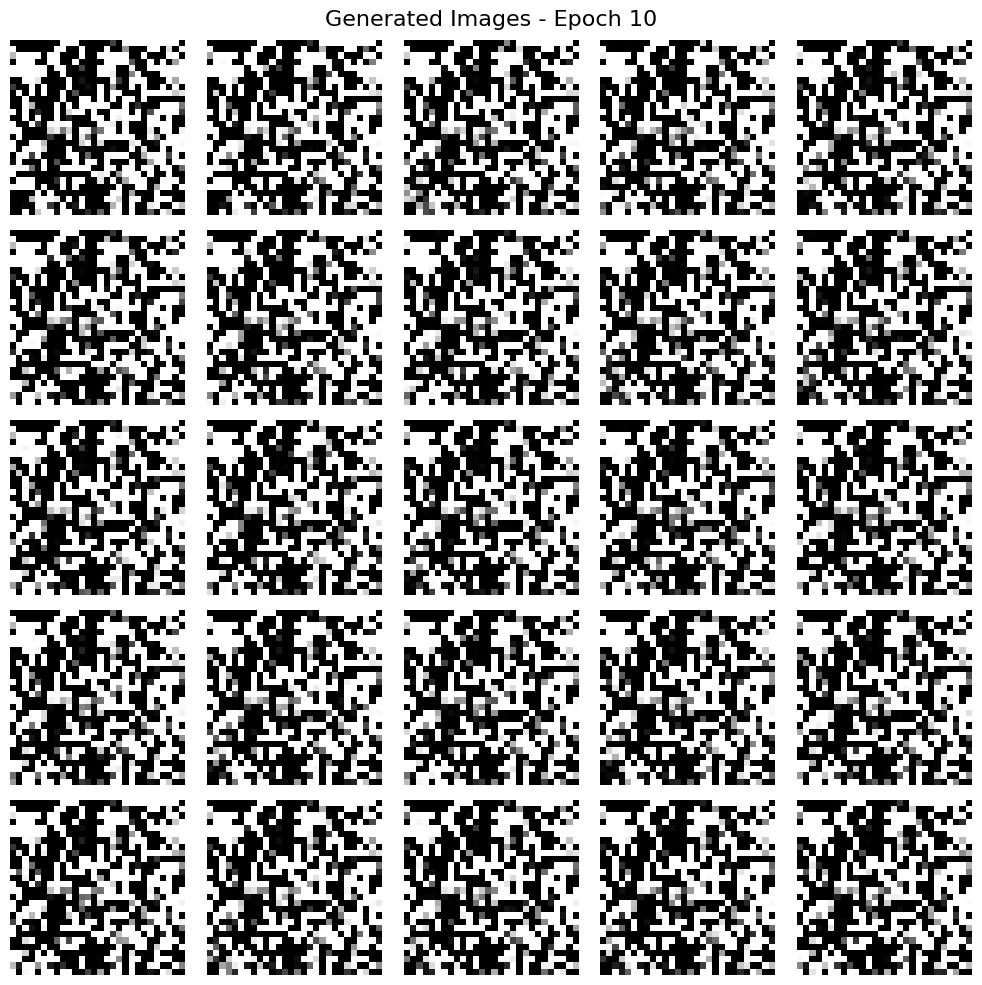

Epoch 11/50 | Batch 0/468 | D_loss: 0.9226 | D_acc: 50.0% | G_loss: 0.3676
Epoch 11/50 | Batch 100/468 | D_loss: 0.9231 | D_acc: 50.0% | G_loss: 0.3671
Epoch 11/50 | Batch 200/468 | D_loss: 0.9236 | D_acc: 50.0% | G_loss: 0.3666
Epoch 11/50 | Batch 300/468 | D_loss: 0.9242 | D_acc: 50.0% | G_loss: 0.3661
Epoch 11/50 | Batch 400/468 | D_loss: 0.9247 | D_acc: 50.0% | G_loss: 0.3656

EPOCH 11 SUMMARY
D_loss: 0.9238 | D_acc: 50.0% | G_loss: 0.3664
✅ GOOD: Training is balanced!

Epoch 12/50 | Batch 0/468 | D_loss: 0.9250 | D_acc: 50.0% | G_loss: 0.3653
Epoch 12/50 | Batch 100/468 | D_loss: 0.9255 | D_acc: 50.0% | G_loss: 0.3648
Epoch 12/50 | Batch 200/468 | D_loss: 0.9260 | D_acc: 50.0% | G_loss: 0.3644
Epoch 12/50 | Batch 300/468 | D_loss: 0.9265 | D_acc: 50.0% | G_loss: 0.3639
Epoch 12/50 | Batch 400/468 | D_loss: 0.9270 | D_acc: 50.0% | G_loss: 0.3635

EPOCH 12 SUMMARY
D_loss: 0.9262 | D_acc: 50.0% | G_loss: 0.3642
✅ GOOD: Training is balanced!

Epoch 13/50 | Batch 0/468 | D_loss: 0.9273

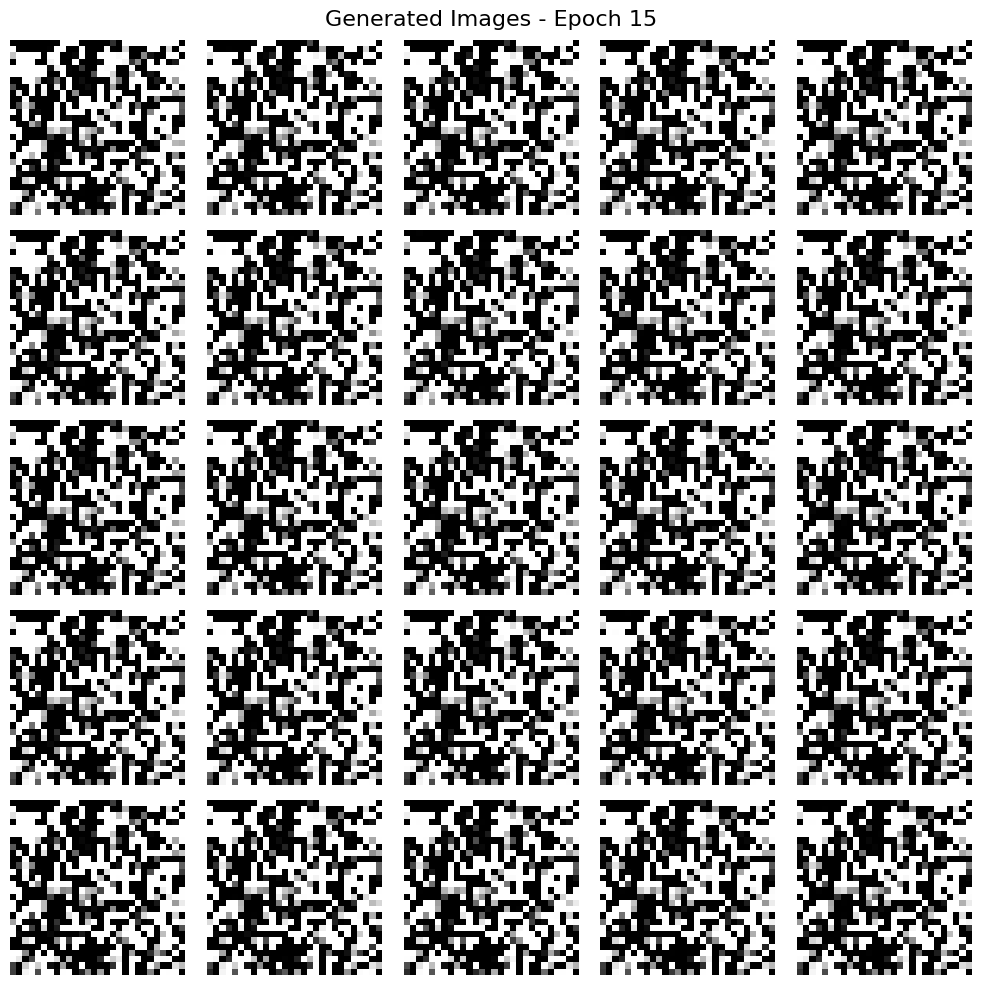

Epoch 16/50 | Batch 0/468 | D_loss: 0.9327 | D_acc: 50.0% | G_loss: 0.3582
Epoch 16/50 | Batch 100/468 | D_loss: 0.9331 | D_acc: 50.0% | G_loss: 0.3579
Epoch 16/50 | Batch 200/468 | D_loss: 0.9334 | D_acc: 50.0% | G_loss: 0.3576
Epoch 16/50 | Batch 300/468 | D_loss: 0.9337 | D_acc: 50.0% | G_loss: 0.3573
Epoch 16/50 | Batch 400/468 | D_loss: 0.9340 | D_acc: 50.0% | G_loss: 0.3571

EPOCH 16 SUMMARY
D_loss: 0.9335 | D_acc: 50.0% | G_loss: 0.3575
✅ GOOD: Training is balanced!

Epoch 17/50 | Batch 0/468 | D_loss: 0.9342 | D_acc: 50.0% | G_loss: 0.3569
Epoch 17/50 | Batch 100/468 | D_loss: 0.9345 | D_acc: 50.0% | G_loss: 0.3566
Epoch 17/50 | Batch 200/468 | D_loss: 0.9348 | D_acc: 50.0% | G_loss: 0.3564
Epoch 17/50 | Batch 300/468 | D_loss: 0.9350 | D_acc: 50.0% | G_loss: 0.3561
Epoch 17/50 | Batch 400/468 | D_loss: 0.9353 | D_acc: 50.0% | G_loss: 0.3559

EPOCH 17 SUMMARY
D_loss: 0.9348 | D_acc: 50.0% | G_loss: 0.3563
✅ GOOD: Training is balanced!

Epoch 18/50 | Batch 0/468 | D_loss: 0.9355

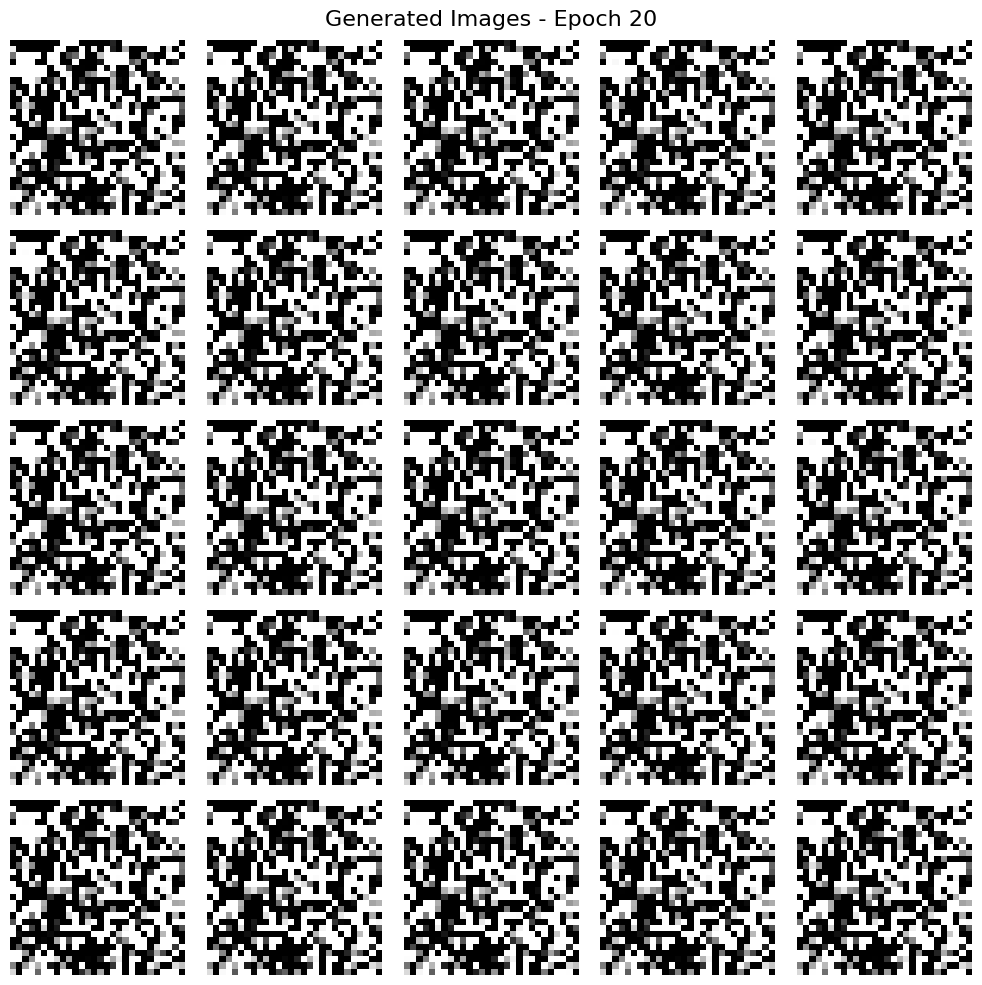

Epoch 21/50 | Batch 0/468 | D_loss: 0.9387 | D_acc: 50.0% | G_loss: 0.3528
Epoch 21/50 | Batch 100/468 | D_loss: 0.9389 | D_acc: 50.0% | G_loss: 0.3526
Epoch 21/50 | Batch 200/468 | D_loss: 0.9391 | D_acc: 50.0% | G_loss: 0.3524
Epoch 21/50 | Batch 300/468 | D_loss: 0.9393 | D_acc: 50.0% | G_loss: 0.3522
Epoch 21/50 | Batch 400/468 | D_loss: 0.9395 | D_acc: 50.0% | G_loss: 0.3520

EPOCH 21 SUMMARY
D_loss: 0.9392 | D_acc: 50.0% | G_loss: 0.3523
✅ GOOD: Training is balanced!

Epoch 22/50 | Batch 0/468 | D_loss: 0.9396 | D_acc: 50.0% | G_loss: 0.3519
Epoch 22/50 | Batch 100/468 | D_loss: 0.9398 | D_acc: 50.0% | G_loss: 0.3518
Epoch 22/50 | Batch 200/468 | D_loss: 0.9400 | D_acc: 50.0% | G_loss: 0.3516
Epoch 22/50 | Batch 300/468 | D_loss: 0.9402 | D_acc: 50.0% | G_loss: 0.3514
Epoch 22/50 | Batch 400/468 | D_loss: 0.9404 | D_acc: 50.0% | G_loss: 0.3513

EPOCH 22 SUMMARY
D_loss: 0.9401 | D_acc: 50.0% | G_loss: 0.3515
✅ GOOD: Training is balanced!

Epoch 23/50 | Batch 0/468 | D_loss: 0.9405

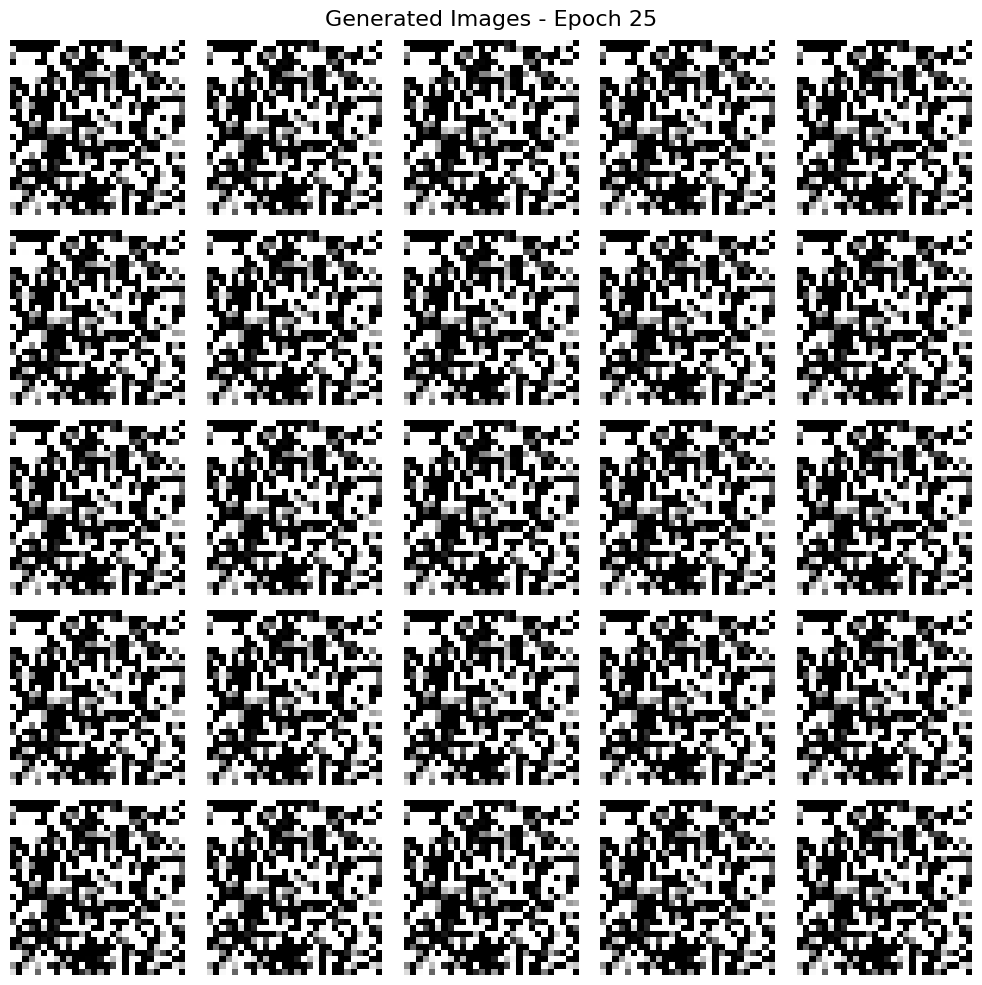

Epoch 26/50 | Batch 0/468 | D_loss: 0.9427 | D_acc: 50.0% | G_loss: 0.3492
Epoch 26/50 | Batch 100/468 | D_loss: 0.9428 | D_acc: 50.0% | G_loss: 0.3491
Epoch 26/50 | Batch 200/468 | D_loss: 0.9430 | D_acc: 50.0% | G_loss: 0.3490
Epoch 26/50 | Batch 300/468 | D_loss: 0.9431 | D_acc: 50.0% | G_loss: 0.3488
Epoch 26/50 | Batch 400/468 | D_loss: 0.9432 | D_acc: 50.0% | G_loss: 0.3487

EPOCH 26 SUMMARY
D_loss: 0.9430 | D_acc: 50.0% | G_loss: 0.3489
✅ GOOD: Training is balanced!

Epoch 27/50 | Batch 0/468 | D_loss: 0.9433 | D_acc: 50.0% | G_loss: 0.3486
Epoch 27/50 | Batch 100/468 | D_loss: 0.9434 | D_acc: 50.0% | G_loss: 0.3485
Epoch 27/50 | Batch 200/468 | D_loss: 0.9436 | D_acc: 50.0% | G_loss: 0.3484
Epoch 27/50 | Batch 300/468 | D_loss: 0.9437 | D_acc: 50.0% | G_loss: 0.3483
Epoch 27/50 | Batch 400/468 | D_loss: 0.9438 | D_acc: 50.0% | G_loss: 0.3482

EPOCH 27 SUMMARY
D_loss: 0.9436 | D_acc: 50.0% | G_loss: 0.3484
✅ GOOD: Training is balanced!

Epoch 28/50 | Batch 0/468 | D_loss: 0.9439

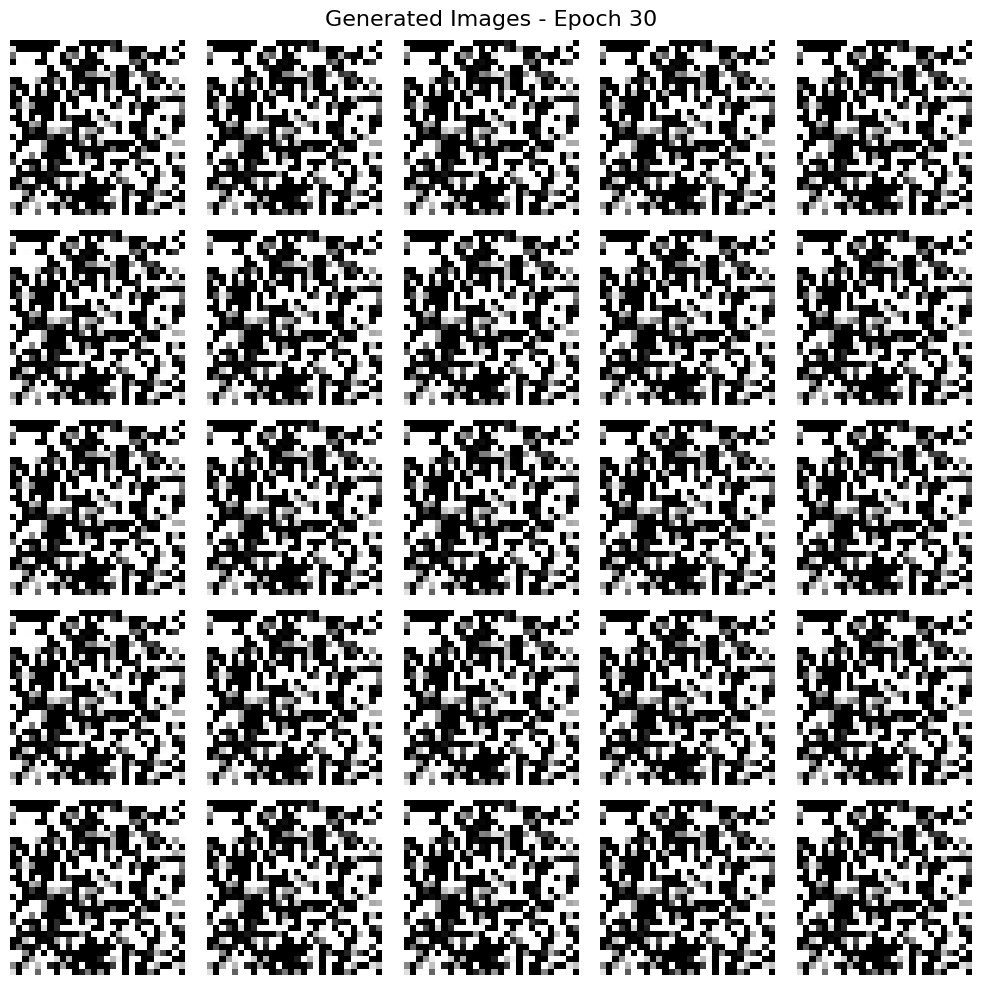

Epoch 31/50 | Batch 0/468 | D_loss: 0.9454 | D_acc: 50.0% | G_loss: 0.3467
Epoch 31/50 | Batch 100/468 | D_loss: 0.9455 | D_acc: 50.0% | G_loss: 0.3467
Epoch 31/50 | Batch 200/468 | D_loss: 0.9456 | D_acc: 50.0% | G_loss: 0.3466
Epoch 31/50 | Batch 300/468 | D_loss: 0.9457 | D_acc: 50.0% | G_loss: 0.3465
Epoch 31/50 | Batch 400/468 | D_loss: 0.9458 | D_acc: 50.0% | G_loss: 0.3464

EPOCH 31 SUMMARY
D_loss: 0.9456 | D_acc: 50.0% | G_loss: 0.3465
✅ GOOD: Training is balanced!

Epoch 32/50 | Batch 0/468 | D_loss: 0.9459 | D_acc: 50.0% | G_loss: 0.3464
Epoch 32/50 | Batch 100/468 | D_loss: 0.9460 | D_acc: 50.0% | G_loss: 0.3463
Epoch 32/50 | Batch 200/468 | D_loss: 0.9460 | D_acc: 50.0% | G_loss: 0.3462
Epoch 32/50 | Batch 300/468 | D_loss: 0.9461 | D_acc: 50.0% | G_loss: 0.3461
Epoch 32/50 | Batch 400/468 | D_loss: 0.9462 | D_acc: 50.0% | G_loss: 0.3460

EPOCH 32 SUMMARY
D_loss: 0.9461 | D_acc: 50.0% | G_loss: 0.3462
✅ GOOD: Training is balanced!

Epoch 33/50 | Batch 0/468 | D_loss: 0.9463

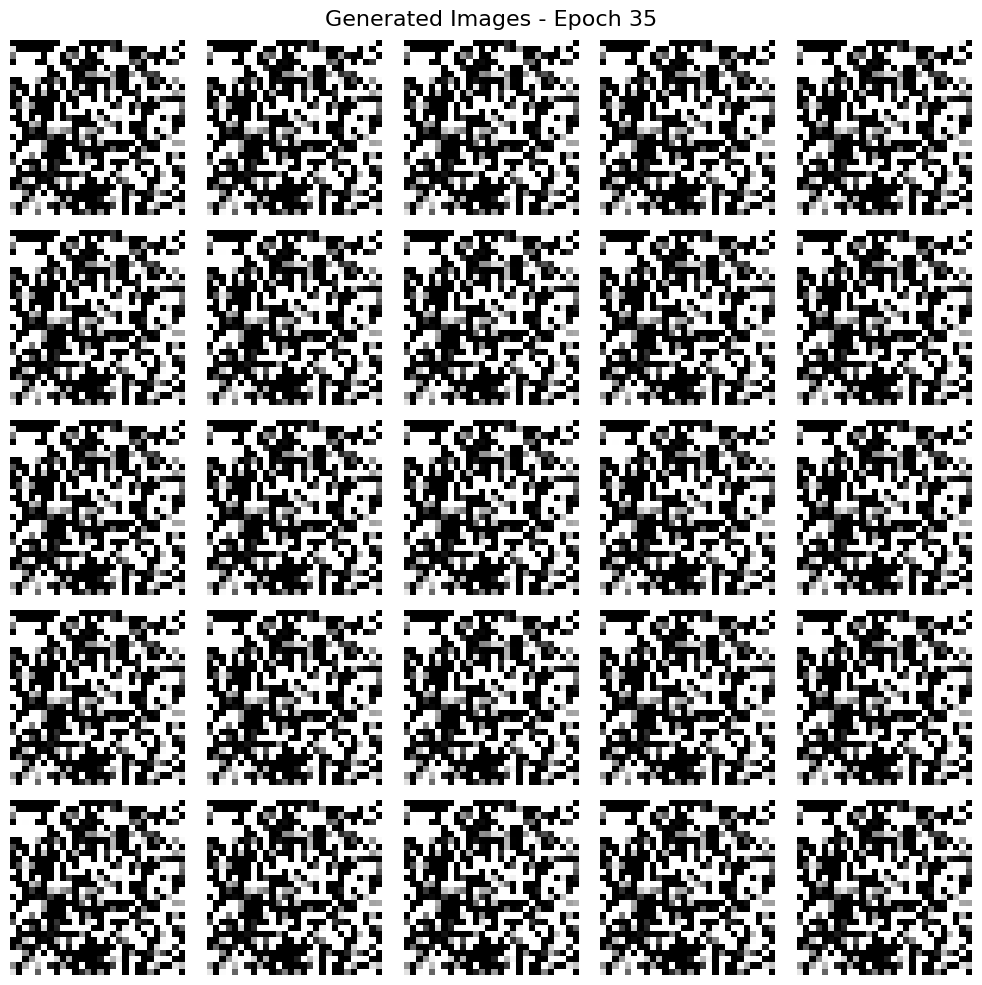

Epoch 36/50 | Batch 0/468 | D_loss: 0.9474 | D_acc: 50.0% | G_loss: 0.3450
Epoch 36/50 | Batch 100/468 | D_loss: 0.9475 | D_acc: 50.0% | G_loss: 0.3449
Epoch 36/50 | Batch 200/468 | D_loss: 0.9475 | D_acc: 50.0% | G_loss: 0.3449
Epoch 36/50 | Batch 300/468 | D_loss: 0.9476 | D_acc: 50.0% | G_loss: 0.3448
Epoch 36/50 | Batch 400/468 | D_loss: 0.9477 | D_acc: 50.0% | G_loss: 0.3447

EPOCH 36 SUMMARY
D_loss: 0.9476 | D_acc: 50.0% | G_loss: 0.3448
✅ GOOD: Training is balanced!

Epoch 37/50 | Batch 0/468 | D_loss: 0.9477 | D_acc: 50.0% | G_loss: 0.3447
Epoch 37/50 | Batch 100/468 | D_loss: 0.9478 | D_acc: 50.0% | G_loss: 0.3446
Epoch 37/50 | Batch 200/468 | D_loss: 0.9478 | D_acc: 50.0% | G_loss: 0.3446
Epoch 37/50 | Batch 300/468 | D_loss: 0.9479 | D_acc: 50.0% | G_loss: 0.3445
Epoch 37/50 | Batch 400/468 | D_loss: 0.9480 | D_acc: 50.0% | G_loss: 0.3445

EPOCH 37 SUMMARY
D_loss: 0.9479 | D_acc: 50.0% | G_loss: 0.3446
✅ GOOD: Training is balanced!

Epoch 38/50 | Batch 0/468 | D_loss: 0.9480

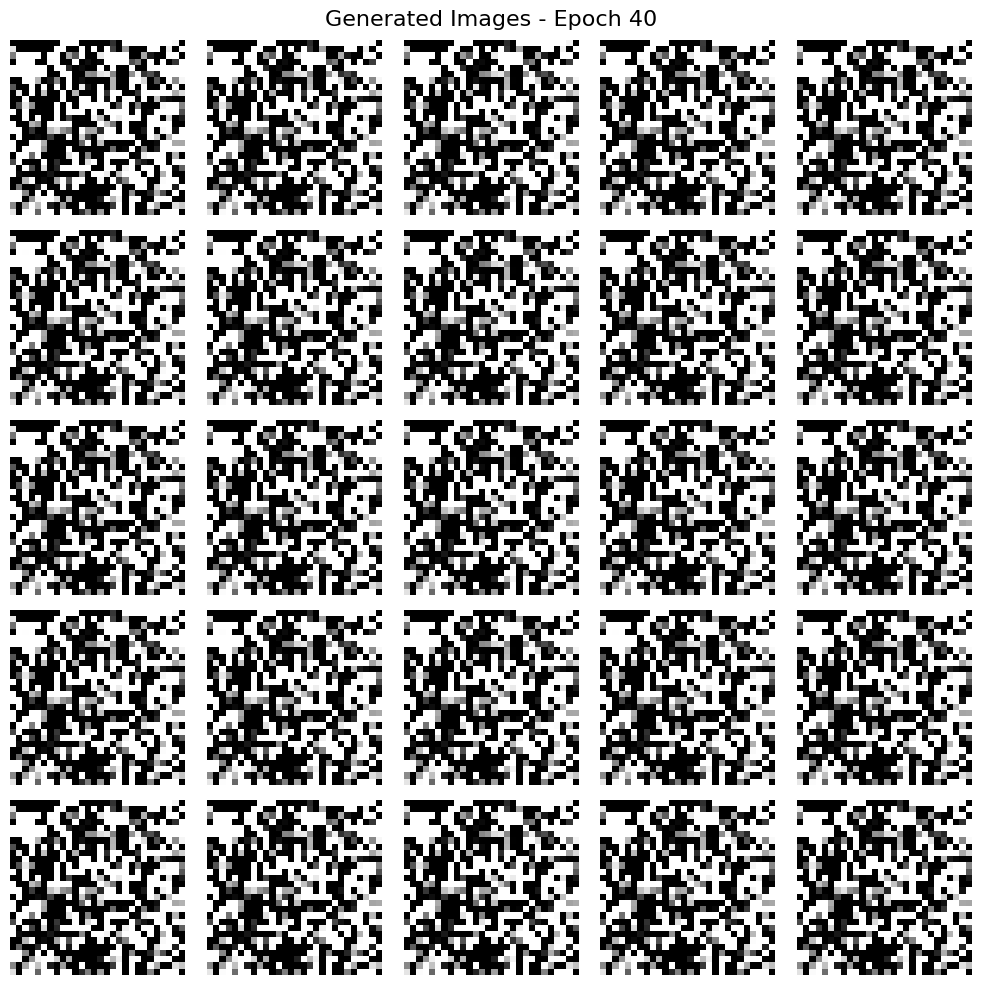

Epoch 41/50 | Batch 0/468 | D_loss: 0.9488 | D_acc: 50.0% | G_loss: 0.3437
Epoch 41/50 | Batch 100/468 | D_loss: 0.9489 | D_acc: 50.0% | G_loss: 0.3436
Epoch 41/50 | Batch 200/468 | D_loss: 0.9490 | D_acc: 50.0% | G_loss: 0.3436
Epoch 41/50 | Batch 300/468 | D_loss: 0.9490 | D_acc: 50.0% | G_loss: 0.3435
Epoch 41/50 | Batch 400/468 | D_loss: 0.9491 | D_acc: 50.0% | G_loss: 0.3435

EPOCH 41 SUMMARY
D_loss: 0.9490 | D_acc: 50.0% | G_loss: 0.3436
✅ GOOD: Training is balanced!

Epoch 42/50 | Batch 0/468 | D_loss: 0.9491 | D_acc: 50.0% | G_loss: 0.3435
Epoch 42/50 | Batch 100/468 | D_loss: 0.9491 | D_acc: 50.0% | G_loss: 0.3434
Epoch 42/50 | Batch 200/468 | D_loss: 0.9492 | D_acc: 50.0% | G_loss: 0.3434
Epoch 42/50 | Batch 300/468 | D_loss: 0.9492 | D_acc: 50.0% | G_loss: 0.3433
Epoch 42/50 | Batch 400/468 | D_loss: 0.9493 | D_acc: 50.0% | G_loss: 0.3433

EPOCH 42 SUMMARY
D_loss: 0.9492 | D_acc: 50.0% | G_loss: 0.3433
✅ GOOD: Training is balanced!

Epoch 43/50 | Batch 0/468 | D_loss: 0.9493

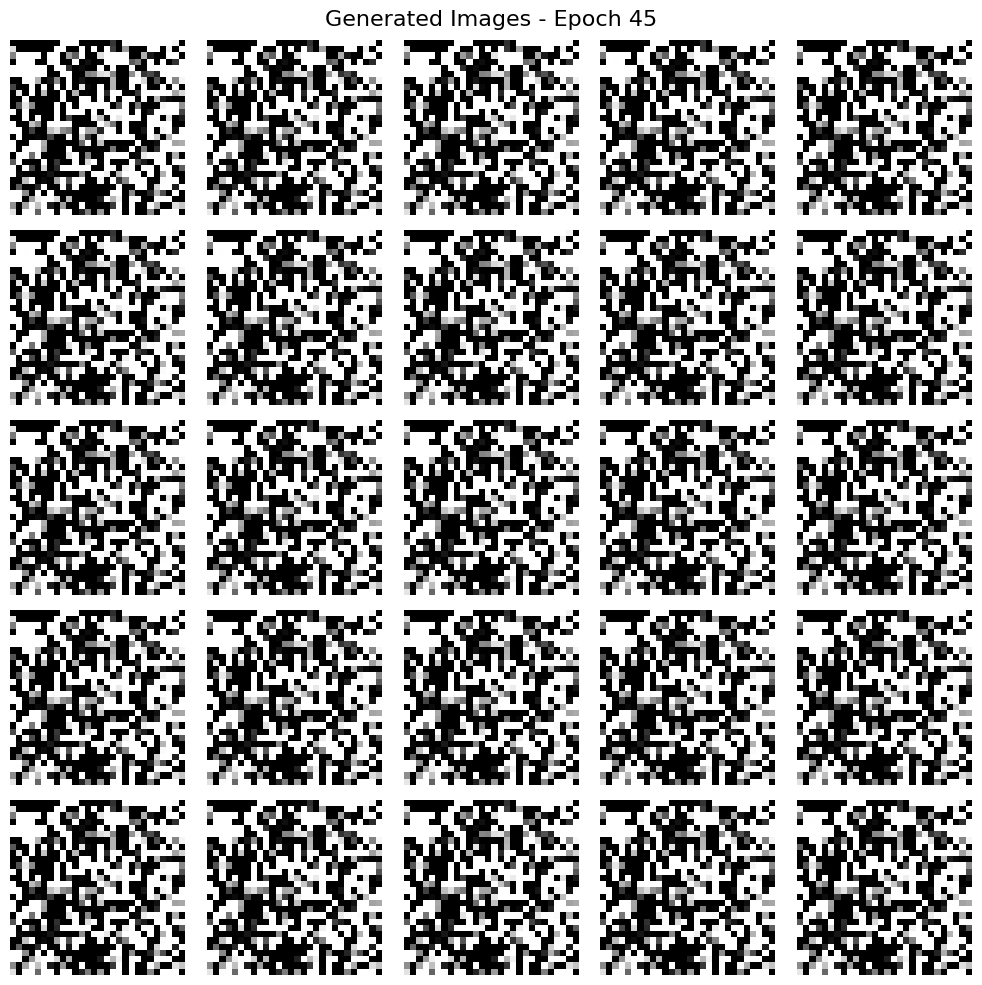

Epoch 46/50 | Batch 0/468 | D_loss: 0.9500 | D_acc: 50.0% | G_loss: 0.3426
Epoch 46/50 | Batch 100/468 | D_loss: 0.9500 | D_acc: 50.0% | G_loss: 0.3426
Epoch 46/50 | Batch 200/468 | D_loss: 0.9501 | D_acc: 50.0% | G_loss: 0.3426
Epoch 46/50 | Batch 300/468 | D_loss: 0.9501 | D_acc: 50.0% | G_loss: 0.3425
Epoch 46/50 | Batch 400/468 | D_loss: 0.9501 | D_acc: 50.0% | G_loss: 0.3425

EPOCH 46 SUMMARY
D_loss: 0.9501 | D_acc: 50.0% | G_loss: 0.3426
✅ GOOD: Training is balanced!

Epoch 47/50 | Batch 0/468 | D_loss: 0.9502 | D_acc: 50.0% | G_loss: 0.3425
Epoch 47/50 | Batch 100/468 | D_loss: 0.9502 | D_acc: 50.0% | G_loss: 0.3424
Epoch 47/50 | Batch 200/468 | D_loss: 0.9503 | D_acc: 50.0% | G_loss: 0.3424
Epoch 47/50 | Batch 300/468 | D_loss: 0.9503 | D_acc: 50.0% | G_loss: 0.3424
Epoch 47/50 | Batch 400/468 | D_loss: 0.9503 | D_acc: 50.0% | G_loss: 0.3423

EPOCH 47 SUMMARY
D_loss: 0.9503 | D_acc: 50.0% | G_loss: 0.3424
✅ GOOD: Training is balanced!

Epoch 48/50 | Batch 0/468 | D_loss: 0.9504

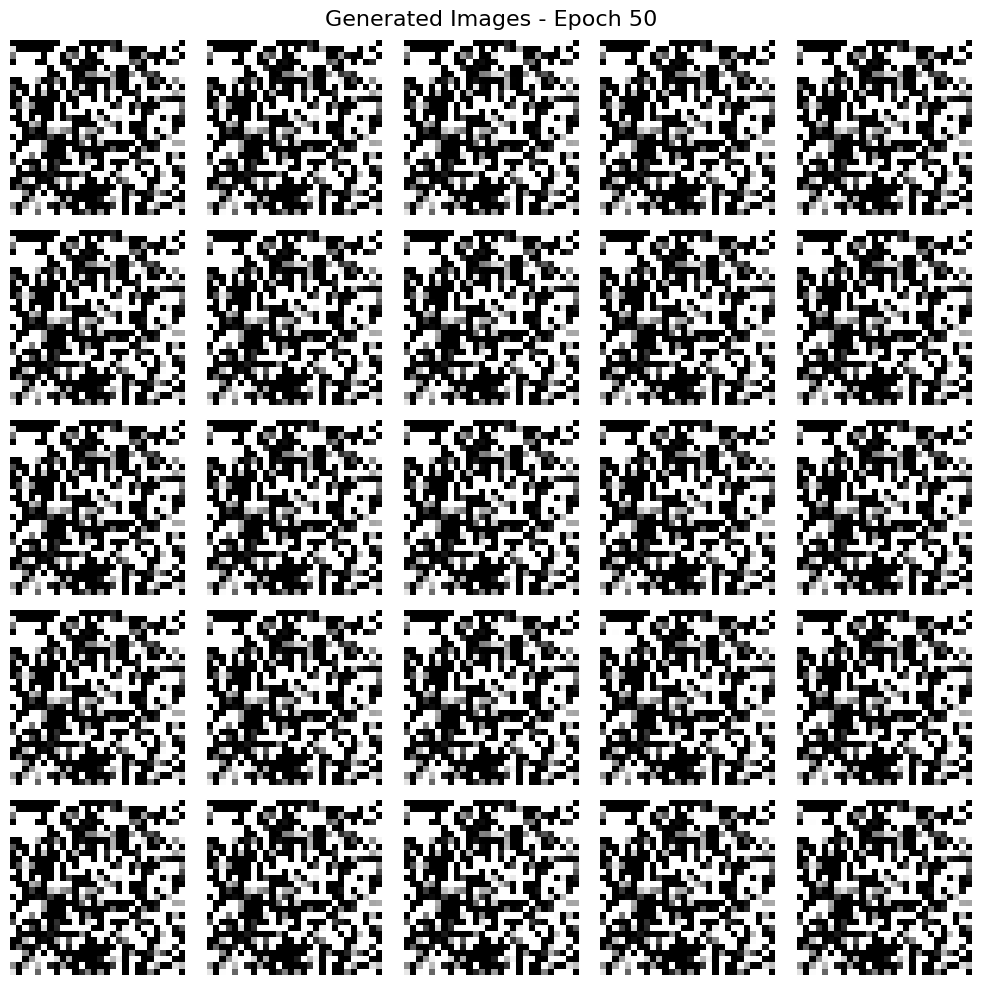


Plotting training history...


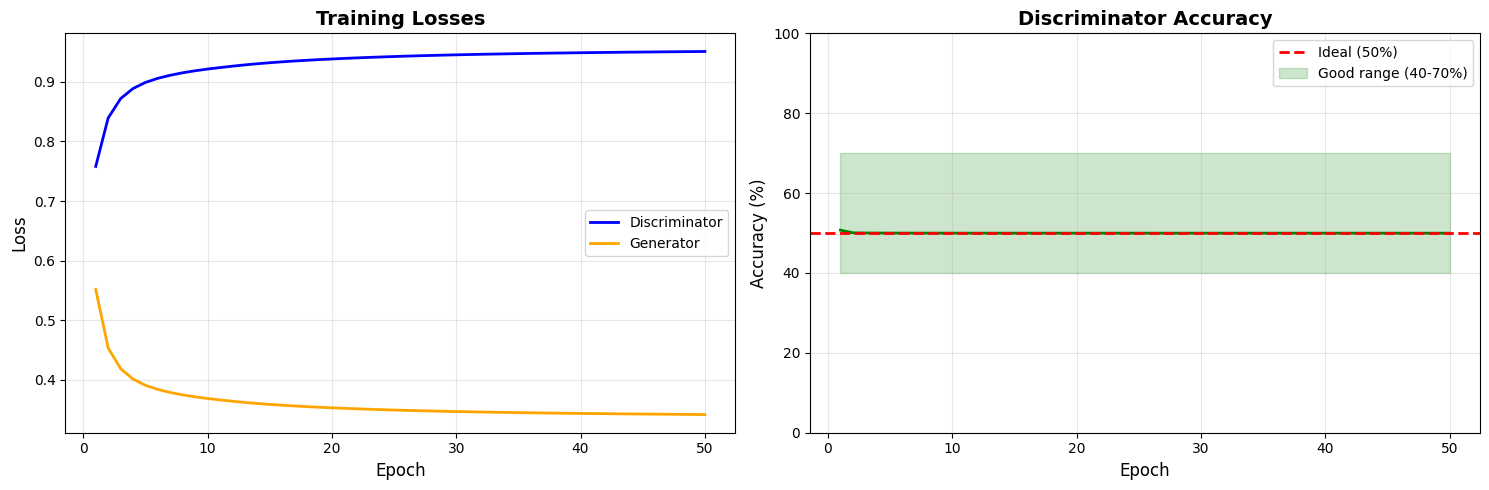


Generating final samples...


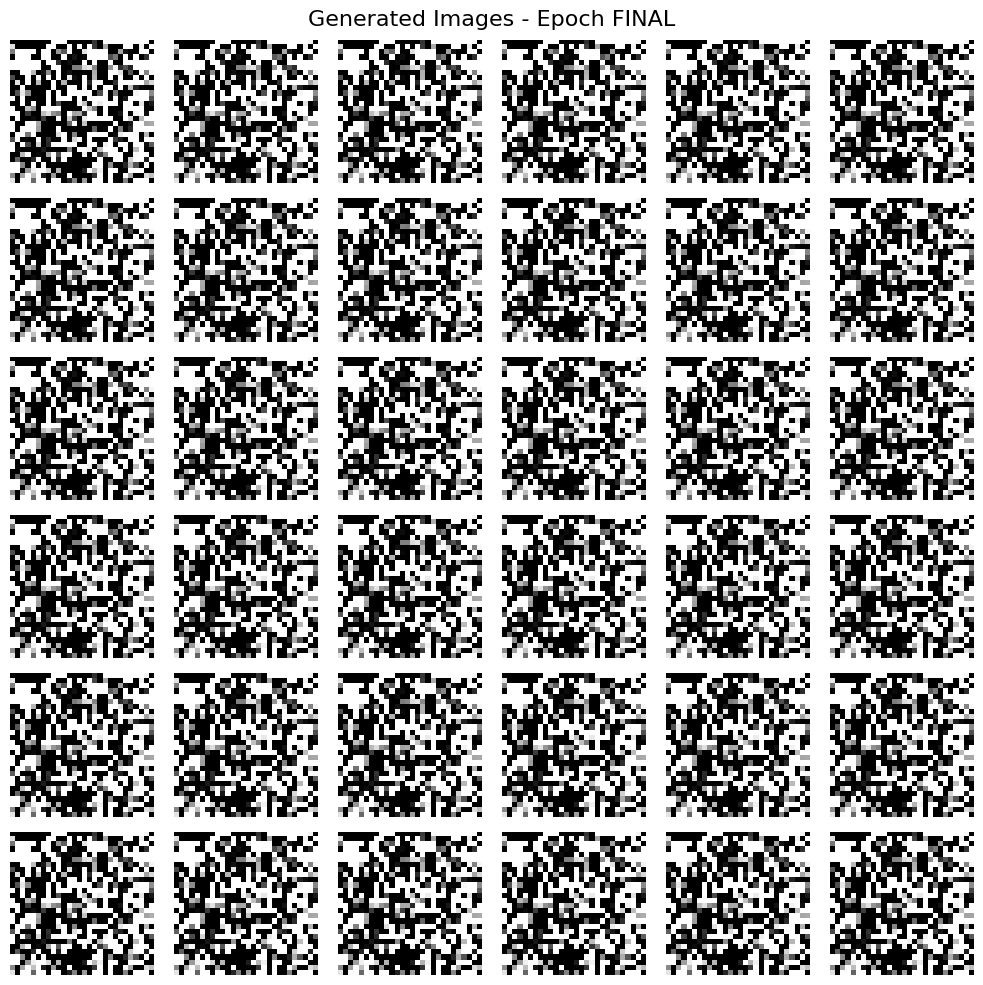


TRAINING COMPLETE!

📊 Final Performance:
   D_loss: 0.9508
   G_loss: 0.3419
   D_acc:  50.0%

✅ EXCELLENT: Discriminator accuracy in ideal range!
   Training is well-balanced. Generated images should be high quality.

💡 Next Steps if results not perfect:
   - Run more epochs (try 100)
   - Adjust batch size (try 256)
   - Fine-tune learning rates


In [3]:
# ==========================================
# MAIN EXECUTION
# ==========================================

gan = BalancedDCGAN()

print("="*70)
print("GENERATOR ARCHITECTURE")
print("="*70)
gan.generator.summary()

print("\n" + "="*70)
print("DISCRIMINATOR ARCHITECTURE (No Dropout, More Filters)")
print("="*70)
gan.discriminator.summary()

# Generate pre-training samples
print("\nPre-training samples (should be noise)...")
gan.generate_images(0)

# Train
print("\nStarting training with balanced settings...")
history = gan.train(epochs=EPOCHS, batch_size=BATCH_SIZE)

# Plot results
print("\nPlotting training history...")
gan.plot_history(history)

# Generate final samples
print("\nGenerating final samples...")
gan.generate_images('FINAL', n=36)

print("\n" + "="*70)
print("TRAINING COMPLETE!")
print("="*70)
print("\n📊 Final Performance:")
print(f"   D_loss: {history['d_loss'][-1]:.4f}")
print(f"   G_loss: {history['g_loss'][-1]:.4f}")
print(f"   D_acc:  {history['d_acc'][-1]:.1f}%")
print()

if 40 <= history['d_acc'][-1] <= 70:
    print("✅ EXCELLENT: Discriminator accuracy in ideal range!")
    print("   Training is well-balanced. Generated images should be high quality.")
elif history['d_acc'][-1] > 80:
    print("⚠️  Discriminator too strong")
    print("   Consider: Lower D_LR or add slight Dropout")
elif history['d_acc'][-1] < 30:
    print("⚠️  Generator too strong")
    print("   Consider: Higher D_LR or train D more times per batch")
else:
    print("✅ Training converged reasonably well")

print("\n💡 Next Steps if results not perfect:")
print("   - Run more epochs (try 100)")
print("   - Adjust batch size (try 256)")
print("   - Fine-tune learning rates")